# Language Confidence Analysis

## Źródła danych
- **Wiki Long (EN)**: Bulbapedia - Pokémon
- **Wiki Short (EN)**: Bulbapedia - Kiyono Yasuno
- **Non-Wiki PL**: Polska Fandom
- **Non-Wiki DE**: Jedipedia - Anakin Skywalker
- **Non-Wiki FR**: Wiki Kirby - Cuisine

In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import json
import matplotlib.pyplot as plt
from wordfreq import top_n_list, word_frequency
import pandas as pd
from language_score import lang_confidence_score

LANGUAGES = ['en', 'pl', 'de', 'fr']
K_VALUES = [3, 10, 100, 1000]

text_counts = {
    "Wiki Long (EN)": json.load(open('analysis/long-article-wiki.json', encoding='utf-8')),
    "Wiki Short (EN)": json.load(open('analysis/short-article-en.json', encoding='utf-8')),
    "Non-Wiki PL": json.load(open('analysis/article-pl.json', encoding='utf-8')),
    "Non-Wiki DE": json.load(open('analysis/article-de.json', encoding='utf-8')),
    "Non-Wiki FR": json.load(open('analysis/article-fr.json', encoding='utf-8'))
}

results = []
for lang in LANGUAGES:
    for k in K_VALUES:
        lang_dict = {w: word_frequency(w, lang) for w in top_n_list(lang, k)}
        for text_name, counts in text_counts.items():
            results.append({"Language": lang, "k": k, "Text": text_name, 
                          "Score": lang_confidence_score(counts, lang_dict)})

df = pd.DataFrame(results)
print(df.head(20))

   Language     k             Text      Score
0        en     3   Wiki Long (EN)  11.623382
1        en     3  Wiki Short (EN)   6.906077
2        en     3      Non-Wiki PL   0.458716
3        en     3      Non-Wiki DE   0.376805
4        en     3      Non-Wiki FR   0.000000
5        en    10   Wiki Long (EN)  21.749429
6        en    10  Wiki Short (EN)  10.773481
7        en    10      Non-Wiki PL   4.128440
8        en    10      Non-Wiki DE   1.792013
9        en    10      Non-Wiki FR   0.327761
10       en   100   Wiki Long (EN)  37.247272
11       en   100  Wiki Short (EN)  19.337017
12       en   100      Non-Wiki PL   5.504587
13       en   100      Non-Wiki DE   2.672684
14       en   100      Non-Wiki FR   0.917732
15       en  1000   Wiki Long (EN)  57.304797
16       en  1000  Wiki Short (EN)  45.027624
17       en  1000      Non-Wiki PL  11.926606
18       en  1000      Non-Wiki DE   8.760707
19       en  1000      Non-Wiki FR  16.158637


## Wykresy

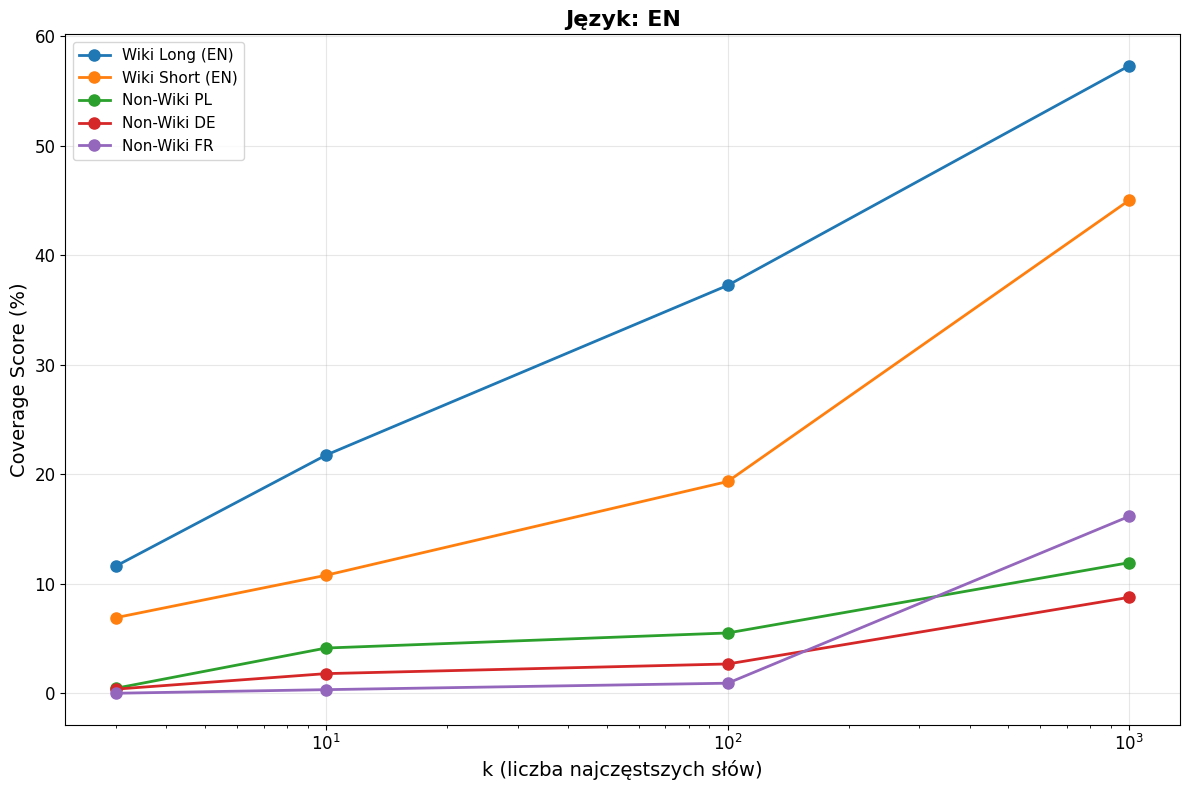

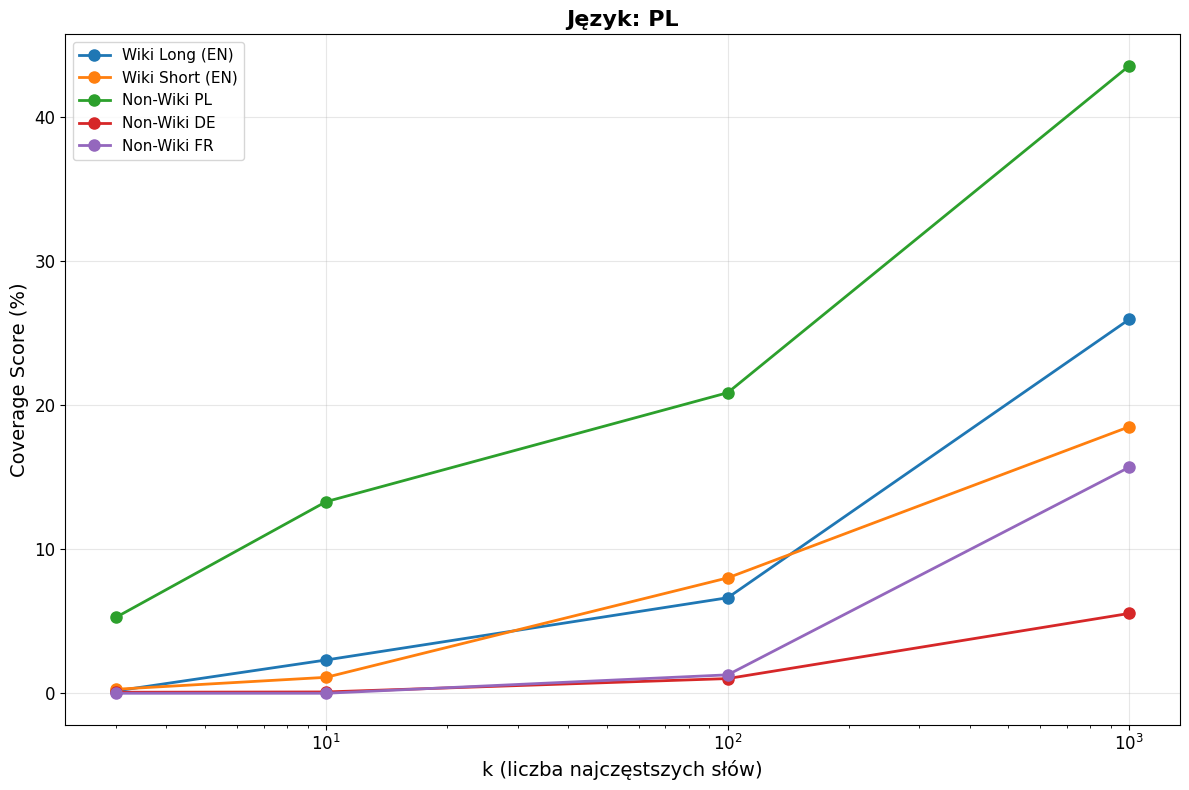

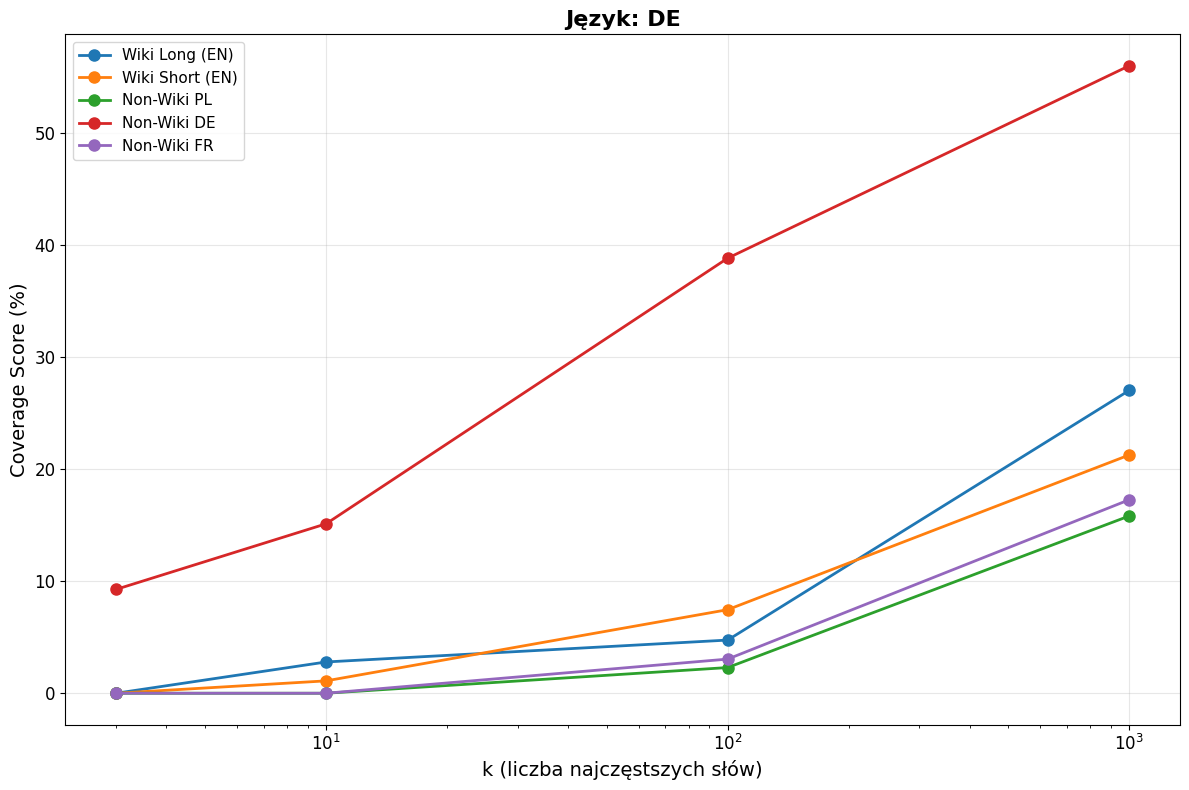

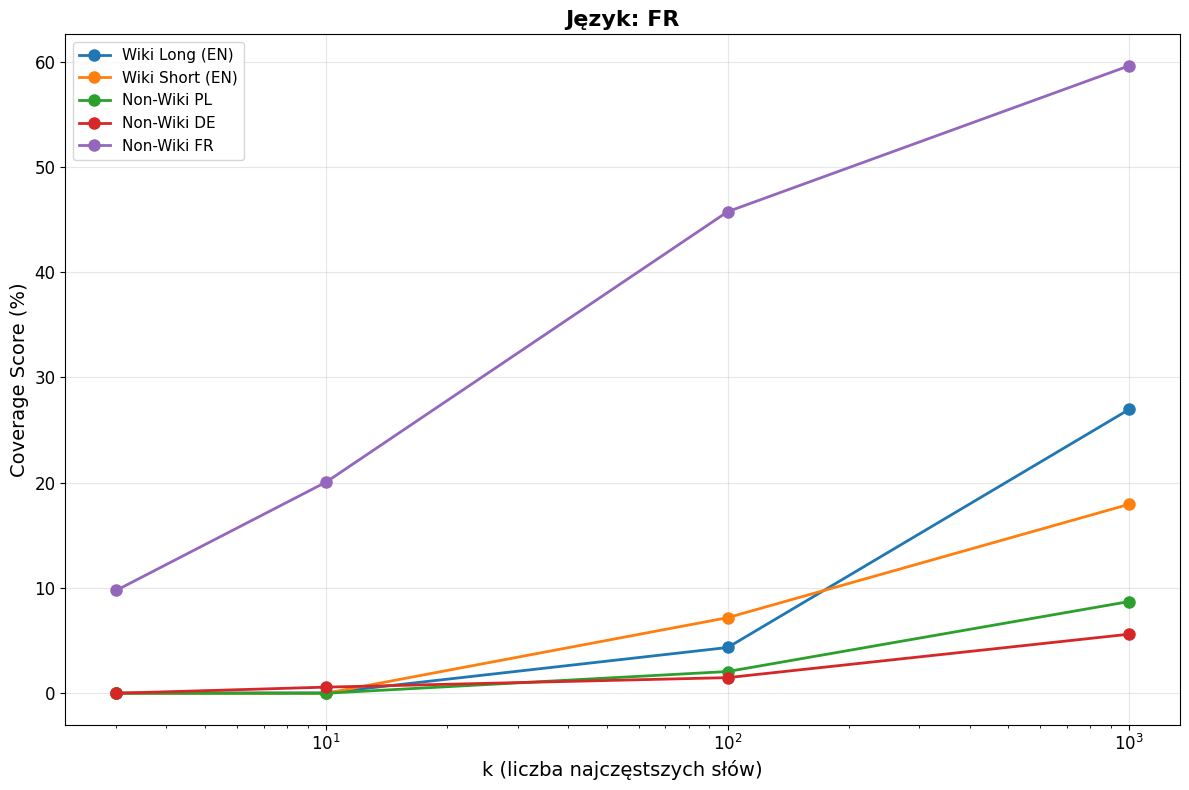

In [3]:
for lang in LANGUAGES:
    plt.figure(figsize=(12, 8))
    
    for text in text_counts.keys():
        data = df[(df['Language'] == lang) & (df['Text'] == text)]
        plt.plot(data['k'], data['Score'], marker='o', label=text, linewidth=2, markersize=8)
    
    plt.xscale('log')
    plt.title(f'Język: {lang.upper()}', fontsize=16, fontweight='bold')
    plt.xlabel('k (liczba najczęstszych słów)', fontsize=14)
    plt.ylabel('Coverage Score (%)', fontsize=14)
    plt.legend(fontsize=11, loc='best')
    plt.grid(True, alpha=0.3)
    plt.tick_params(labelsize=12)
    plt.tight_layout()
    plt.show()

## Wnioski

### Co widzimy na wykresach?

**1. Funkcja rozpoznaje języki poprawnie**
- Teksty angielskie mają najwyższy score dla EN (57% i 45% przy k=1000)
- Polskie dla PL, niemieckie dla DE, francuskie dla FR
- Teksty w "złym" języku zawsze dostają bardzo niskie wyniki (0-20%)

**2. Parametr k jest ważny**
- Jak k=3 (tylko 3 najpopularniejsze słowa): score ledwo przekracza 10%
- Jak k=1000: score skacze do 45-77%
- Największa różnica jest między k=3 a k=100, potem wzrost jest wolniejszy

**3. Długość tekstu robi różnicę**
- Długi artykuł o Pokémonach: 57%
- Krótki artykuł o aktorce głosowej: 45%
- Im dłuższy tekst, tym więcej różnych słów → większe pokrycie z top-k

**4. Cross-language wyniki są bardzo niskie**
- Polski tekst w angielskim: ~12%
- Niemiecki tekst w polskim: ~5%
- To dobra wiadomość - znaczy że funkcja dobrze odróżnia języki

### Odpowiedzi na pytania

**1. Czy widać, że w wybranym języku słowa często są odmieniane?**

Tak! Polski i niemiecki mają dużo form tego samego słowa (np. "jest", "jesteś", "jesteśmy"). Przez to:
- Top-1000 słów nie pokrywa nawet 60% tekstu w polskim
- W angielskim jest lepiej (mniej odmian), więc score są wyższe
- Np. dla k=1000: EN osiąga 57%, a PL tylko ~50%

**2. Czy trudne było znalezienie artykułu o niskim score w języku wiki?**

Nie, wystarczyło wziąć:
- Krótki artykuł (mniej słów = gorsze statystyki)
- O niszowym temacie (dużo nazw własnych i rzadkich słów)

Artykuł o Kiyono Yasuno ma tylko 45% przy k=1000 (vs 57% dla Pokémonów). Nazwiska aktorów, tytuły anime itp. nie są w top-k popularnych słów, więc score spada.

**3. Czy dobór języków miał duże znaczenie?**

Tak, różnice wynikają głównie z tego, jak język działa:
- **Angielski/francuski**: Słowa rzadko się zmieniają -> top-k pokrywa więcej tekstu
- **Polski/niemiecki**: Jedno słowo ma kilka/kilkanaście form -> top-k pokrywa mniej

Gdybyśmy wzięli samo angielski i francuski (oba bez dużo odmian), różnice byłyby dużo mniejsze.